In [3]:
import json
import requests
import os
file_path = os.path.join(os.getcwd(), "test_images/test_nums.json")

with open(file_path) as json_file:
  json_data = json.load(json_file)
input_data = json.dumps(json_data)
scoring_url = 'http://96c4c5ac-e9fc-4f5b-8142-33094c24aff1.centralus.azurecontainer.io/score'
headers = { 'Content-Type': 'application/json' }
response = requests.post(scoring_url, input_data, headers=headers)
print(json.loads(response.text))

[5, 7, 9, 9, 5, 9, 9, 7, 9, 5]


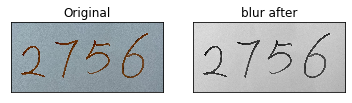

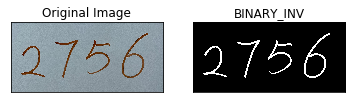

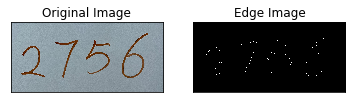

In [35]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
image_path = os.path.join(os.getcwd(), 'test_images/test_num1.jpg')
img = cv.imread(image_path)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
blur = cv.GaussianBlur(gray,(5,5),0)

ret,thresh = cv.threshold(blur, 120, 200, cv.THRESH_BINARY_INV)
edges = cv.Canny(thresh, 120, 200)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur,cmap = 'gray'),plt.title('blur after')
plt.xticks([]), plt.yticks([])
plt.show()

titles = ['Original Image','BINARY_INV']
images = [img, thresh]
for i in range(2):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# find contours and get the external one
contours, hier = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

190 455 446 582
822 349 422 694
1382 348 463 626
1563 936 3 3
1420 936 3 5
1593 924 3 3
1595 922 6 4
1599 919 9 5
1609 917 3 3
1611 916 3 3
2054 223 494 826
2087 628 351 394
12


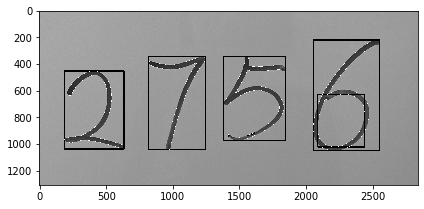

In [36]:
from skimage import io
# with each contour, draw boundingRect in green
# a minAreaRect in red and
# a minEnclosingCircle in blue
for c in contours:
    # get the bounding rect
    x, y, w, h = cv.boundingRect(c)
    # draw a blue rectangle to visualize the bounding rect
    cv.rectangle(blur, (x, y), (x+w, y+h), (0, 0, 255), 8)
    
    print(f'{x} {y} {w} {h}')
    
print(len(contours))

cv.drawContours(blur, contours, -1, (255, 255, 0), 1)

io.imshow(blur)